In [1]:
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
from torch import nn
from dataset import CUB
from utils import *

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
data_root = '../data/CUB-200-2011'
model_name = 'vgg'
torch.manual_seed(0)

In [3]:
if model_name == 'vgg':
    model = torchvision.models.vgg16_bn(pretrained = False).to(device)
elif model_name == 'alexnet':
    model = torchvision.models.alexnet(pretrained = False).to(device)
model.classifier[6] = nn.Linear(4096, 200).to(device)
model.load_state_dict(torch.load(f'model/{model_name}_CUB.pth'))

model.eval()
testset = CUB(data_root, normalization=True, train_test='test')

Plotting the single image


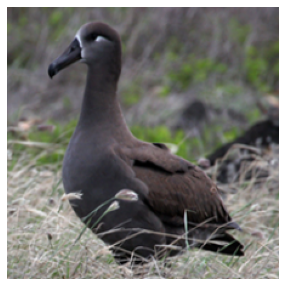

Top class:	2,	confidence = 0.702
Second class:	60,	confidence = 0.268


In [60]:
image_index = 3
image = testset[image_index][0].view(1,3,224,224).to(device)

plot_tensor_image(image)

with torch.no_grad():
    prob = torch.softmax(model(image),dim=1)[0]
    argsort=prob.argsort()
    t1 = argsort[-1]
    t2 = argsort[-2]
print("Top class:\t%d,\tconfidence = %.3f\nSecond class:\t%d,\tconfidence = %.3f"\
      %(t1, prob[t1],t2, prob[t2]))

gradcam = get_saliency(model, image, t1, softmax=False)
contrastive_gradcam = get_saliency(model, image, t1, softmax=True)

# blur the negative areas
blurred_image, contrastive_blurred_image = equal_blur(image, gradcam, contrastive_gradcam, mode='positive')
with torch.no_grad():
    contrastive_blurred_prob = torch.softmax(model(contrastive_blurred_image),dim=1)[0]
    blurred_prob = torch.softmax(model(blurred_image),dim=1)[0]

When the model is not confident given the sample, i.e. $p_{t_1} = p_{max}$ isn't close to 1, then difference between between contrastiveness among classes cannot be overlooked. Let $r=p_{t_1}/(p_{t_1}+p_{t_2})$

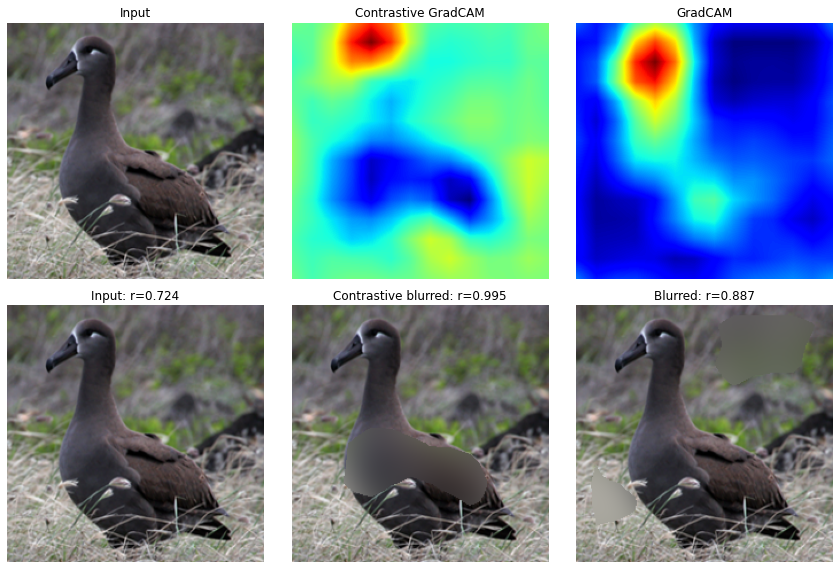

In [61]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
ax = ax.flatten()
ax[0].imshow(denorm(image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[0].set_title('Input')
ax[1].imshow(contrastive_gradcam.detach().cpu().squeeze().numpy(), cmap='jet')
ax[1].set_title('Contrastive GradCAM')
ax[2].imshow(gradcam.detach().cpu().squeeze().numpy(), cmap='jet')
ax[2].set_title('GradCAM')
ax[3].imshow(denorm(image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[3].set_title('Input: r=%.3f'%(prob[t1]/(prob[t2]+prob[t1])))
ax[4].imshow(denorm(contrastive_blurred_image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[4].set_title('Contrastive blurred: r=%.3f'%(contrastive_blurred_prob[t1]/(contrastive_blurred_prob[t2]+contrastive_blurred_prob[t1])))
ax[5].imshow(denorm(blurred_image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[5].set_title('Blurred: r=%.3f'%(blurred_prob[t1]/(blurred_prob[t2]+blurred_prob[t1])))
for i in range(6):
    ax[i].axis('off')
plt.tight_layout()
plt.show()